# A correction to probabilistic classifiers with prior distributions

This is a quick hack to see whether correcting the predicted class probabilities in a classifier, by a factor found from the original prior data distribution and the expected distribution resulting from the classifier, could help with the "minority class is underpredicted" problem.

This notebook is based on [this repo](https://github.com/atorch/areal_estimates_example) by Adrian Torchiana.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs, make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
random_state = 1

### A dataset with some class imbalance

Consider these the fraction of pixels that are forest, pasture, and weeds

In [3]:
true_share = [0.65, 0.3, 0.05]

### Let's make a simple classification dataset with these class proportions

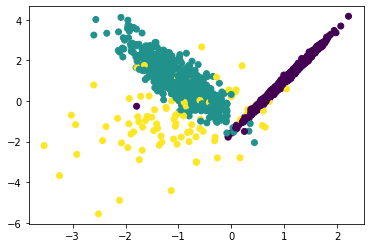

In [4]:
X, y = make_classification(
    n_samples=2_000,
    n_classes=3,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_clusters_per_class=1,
    weights=true_share,
    random_state=random_state,
)

plt.scatter(X[:, 0], X[:, 1], c=y)

In [5]:
# This is an alternative dataset

# # Generate some random X
# rng = np.random.default_rng(seed=random_state)
# X = np.concatenate([
#     rng.standard_normal(size=(2_000, 1)),
#     rng.uniform(size=(2_000, 1)),
# ], axis=1)

# # Generate a non-linear combination of features to classify over
# h = 0.1 * X[:, 0] ** 5 + X[:, 1] + X[:, 0] * X[:, 1] ** 8

# p65 = np.percentile(h, 65)
# p95 = np.percentile(h, 95)

# def label(indicator):
#     if indicator < p65:
#         return 0
#     elif indicator < p95:
#         return 1
#     return 2

# y = [label(i) for i in h]

# plt.scatter(X[:, 0], X[:, 1], c=y)

In [6]:
counts = pd.Series(y).value_counts().rename("Counts").to_frame()
counts["Fraction"] = counts["Counts"] / len(y)
counts

,Counts,Fraction
0,1297,0.6485
1,602,0.3010
2,101,0.0505


### We'll train a simple logistic regressor on this dataset

We're splitting the data down the middle for train and test sets.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)

lr = LogisticRegression(multi_class="ovr", penalty="none", random_state=random_state)
lr.fit(X_train, y_train)

print(f"Logistic regressor's accuracy : {accuracy_score(y_test, lr.predict(X_test))}")

# As an aside... some of these models never predict the minor class
# and that causes issues down the line, so shout about it if so
assert 2 in lr.predict(X_test)

Logistic regressor's accuracy : 0.944


### Let's calculate our "recall matrix"

The (i, j)th entry is the probability that the classifier predicted class $j$, given the datapoint actually belonged to class $i$. That is, 

$$
\mathrm{Recall}_{(i, j)} := Pr\left[ \hat{y} = j \,|\, y = i \right].
$$

In [8]:
def recall_matrix(X_test, y_test, y_hat):
    
    # Empty matrix
    recall = np.zeros((len(true_share), len(true_share)))
    
    # Iterate over each predicted value, comparing to its true (observed) value
    for predicted, actual in zip(y_test, y_hat):
        recall[predicted, actual] += 1
        
    # Normalise on the way out
    return recall / recall.sum(1).reshape(-1, 1)

In [9]:
recall = recall_matrix(X_test, y_test, lr.predict(X_test))
print(f"Our recall matrix :\n\n{recall.round(3)}")

Our recall matrix :

[[0.997 0.002 0.002]
 [0.016 0.957 0.026]
 [0.157 0.647 0.196]]


### Let's look closer.

The diagonals of this matrix should be the classifier's recall for each class.

We can verify that all looks good by comparing with what scikit-learn tells us, too.

In [10]:
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       644
           1       0.90      0.96      0.93       305
           2       0.53      0.20      0.29        51

    accuracy                           0.94      1000
   macro avg       0.80      0.72      0.73      1000
weighted avg       0.93      0.94      0.93      1000



In [11]:
# Pull the recall numbers from sklearn's classification_report
classes = [str(i) for i in set(y_test)]
class_report = classification_report(y_test, lr.predict(X_test), output_dict=True)
sklearn_recall = [class_report[class_]["recall"] for class_ in classes]

print(f"Recall by our calc : {np.diag(recall).round(3)}")
print(f"Recall per sklearn : {np.round(sklearn_recall, 3)}")

Recall by our calc : [0.997 0.957 0.196]
Recall per sklearn : [0.997 0.957 0.196]


### The off-diagonals are useful too.

They tell us about what is being misclassified and where those datapoints are coming from, in terms of their true (observed) classes.

The columns represent all predictions for the observed data. Let's look at the matrix again.

In [12]:
recall

array([[0.99689441, 0.0015528 , 0.0015528 ],
       [0.01639344, 0.95737705, 0.02622951],
       [0.15686275, 0.64705882, 0.19607843]])

In [13]:
for i in range(len(true_share)):
    print(f"{recall[i, 0] * 100:.1f}% of true class-{i} will be predicted as class-0.")

99.7% of true class-0 will be predicted as class-0.
1.6% of true class-1 will be predicted as class-0.
15.7% of true class-2 will be predicted as class-0.


### We can use this information to determine what class distribution we'll get out of the model.

Simply doing the same as in the last cell, as a matrix operation :

In [14]:
predicted_share = true_share @ recall
print(f"Predicted class distribution : {predicted_share}")

Predicted class distribution : [0.66074254 0.32057537 0.01868209]


In [15]:
predicted_counts = pd.Series(lr.predict(X_test)).value_counts()
original_counts = counts["Fraction"]

In [16]:
# Let's confirm
predicted_counts = pd.Series(lr.predict(X_test)).value_counts()
predicted_counts = predicted_counts.rename("Predicted").to_frame() / len(X_test)
original_counts = counts["Fraction"].rename("Original")
predicted_vs_original = pd.concat([original_counts, predicted_counts], axis=1)
predicted_vs_original

,Original,Predicted
0,0.6485,0.655
1,0.3010,0.326
2,0.0505,0.019


### Can we use this to "correct" our classifier ?

Knowing that it significantly underpredicts our minority class, can we change the decision function of this classifier to take these into account ?

In [17]:
# We are using a One-vs-Rest classifier; it should give us the probability
# of a datapoint belonging to some class, rather than any other class
lr.predict_proba(X_test)

array([[9.54413954e-01, 3.61101780e-02, 9.47586779e-03],
       [9.65422391e-01, 3.37825253e-02, 7.95083391e-04],
       [9.71454728e-01, 2.75012376e-02, 1.04403400e-03],
       ...,
       [9.69817614e-01, 2.88835378e-02, 1.29884817e-03],
       [4.86544610e-01, 4.89116568e-01, 2.43388223e-02],
       [9.78729615e-01, 2.12292063e-02, 4.11786828e-05]])

In [18]:
# Let's make sure we're simply assigning class labels according to the largest probability
def class_labels_from_probas(probas):
    return np.argmax(probas, axis=1)

(lr.predict(X_test) == class_labels_from_probas(lr.predict_proba(X_test))).all()

True

In [19]:
# Let's calculate a scaling factor to "correct" for distributional shift
scaling = predicted_vs_original["Original"] / predicted_vs_original["Predicted"]
scaling = scaling.to_numpy()
scaling

array([0.99007634, 0.92331288, 2.65789474])

In [20]:
# Let's generate new class labels from our probabilities
predicted_probas = lr.predict_proba(X_test) * scaling
new_class_labels = class_labels_from_probas(predicted_probas)

In [21]:
# How did we do ?
print("AFTER CORRECTION")
print(classification_report(y_test, new_class_labels))

AFTER CORRECTION
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       644
           1       0.95      0.90      0.92       305
           2       0.47      0.59      0.52        51

    accuracy                           0.94      1000
   macro avg       0.80      0.82      0.81      1000
weighted avg       0.95      0.94      0.94      1000



In [22]:
# Our old metrics :
print("BEFORE CORRECTION")
print(classification_report(y_test, lr.predict(X_test)))

BEFORE CORRECTION
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       644
           1       0.90      0.96      0.93       305
           2       0.53      0.20      0.29        51

    accuracy                           0.94      1000
   macro avg       0.80      0.72      0.73      1000
weighted avg       0.93      0.94      0.93      1000



In [23]:
predicted_vs_original["Corrected"] = pd.Series(new_class_labels).value_counts() / len(y_test)
predicted_vs_original

,Original,Predicted,Corrected
0,0.6485,0.655,0.650
1,0.3010,0.326,0.286
2,0.0505,0.019,0.064
